# Investment Case Group Project
***
***

#### Prerequisite

Place following input files at your current working directory before running this code :
1. 'companies.txt'
2. 'rounds2.csv'
3. 'mapping.csv'

#### Import Libraries and set required parameters

In [1]:
# numpy : Numerical & Scientific computing
import numpy as np

# pandas : for tabular data
import pandas as pd

# os : used for operating system dependent functionality
import os

# re : to handle regular expresiions
import re

# matplotlib : data visualization
import matplotlib.pyplot as plt
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline 

# seaborn : advanced visualization
import seaborn as sns

from IPython.display import Image # To view image from location/url

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00

#### Checking the Input File existence
IMPORTANT: dirName is already set to current working directory.

In [2]:
dirName = './'
inputFile = ('companies.txt','rounds2.csv','mapping.csv')

# List Input files present in current working directory
for fileName in os.listdir(dirName):
    if fileName.startswith(inputFile):
        print(fileName+'\t'+str(round((os.path.getsize(dirName+fileName)/1000),0))+' KB')

companies.txt	8965.0 KB
mapping.csv	23.0 KB
rounds2.csv	11846.0 KB


## Checkpoint 1: Data Cleaning

##### Loading datasets into pandas dataframe.

In [3]:
encoding = 'ANSI'
# 'iso-8859-1'

companies = pd.read_csv(inputFile[0],sep='\t',encoding= encoding)
rounds2 = pd.read_csv(inputFile[1],encoding= encoding)

##### Get some insight

In [4]:
companies.head(2)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014


In [5]:
rounds2.head(2)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan


### Table 1.1
#### Q1. How many unique companies are present in rounds2?

In [6]:
# .nunique() wil give Unique count(excludes NA), use .lower() , to bring all values in lower case
# if you use .count(), it will only give total no of rows without excluding duplicates)

print(rounds2.company_permalink.str.lower().nunique())

66368


#### Q2. How many unique companies are present in companies?

In [7]:
print(companies.permalink.str.lower().nunique())

66368


#### Q3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.

In [8]:
#nunique() will give unique values for each column, column with maximum unique counts
#(or where total unique rows = total values in columns) can be considered as unique column

print(list(companies.nunique().sort_values(ascending=False).iloc[0:1].index))

['permalink']


Convert key columns('permalink' & 'company_permalink') of companies & rounds2 dataframe to <b>lower()</b>

In [9]:
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
companies['permalink'] = companies['permalink'].str.lower()

#### Q4. Are there any companies in the rounds2 file which are not  present in companies ?

In [10]:
# Check the existence of a unique column of dataframe1 in unique column of dataframe2
diff = rounds2[rounds2['company_permalink'].isin(companies['permalink'])== False]
print('Yes' if diff.company_permalink.count() > 0 else 'No')
diff

No


,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd


#### Q5. Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame ?

In [11]:
# lower() the key columns of both dataframes, so they can match in case of diffence in case.
companies['permalink'] = companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
master_frame = pd.merge(left = companies,right = rounds2, how ='inner', left_on='permalink',right_on='company_permalink')
print('\nNumber of Records in master_frame: ',master_frame.count()[0])


Number of Records in master_frame:  114949


#### Identify missing values in the master_frame Dataframe
As our whole case study revolves around 'funding_round_type' & 'raised_amount_usd', so let's conentrate on these two columns.

In [12]:
# sum of null values against each column
#master_frame.isnull().sum()

# sum of null values against 'funding_round_type' & 'raised_amount_usd'
master_frame.loc[:,['funding_round_type','raised_amount_usd']].isnull().sum()

funding_round_type        0
raised_amount_usd     19990
dtype: int64

#### Impute missing values

There are multiple ways to impute the missing values for numeric columns :

    1. Delete the row
        
    2. Replace missing value with mean value.
        
    3. Replace missing value with 0.

<font color='blue'>UDF to impute missing values</font>

* impute_values(dataframe,column,approach) will impute missing values by passing following parameters.

In [13]:
def impute_values(dataframe,column,approach):
    '''impute_values function will impute the missing data(numeric) in the dataframe column.
        dataframe :: Dataframe Name
        column    :: Column name(numeric)
        approach  :: 1,2,3 (default value 1)
            1. Delete the row
            2. Replace missing value with mean value.
            3. Replace missing value with 0
    '''
    dataframe_filtered = dataframe.copy()
    if approach == 1:
        dataframe_filtered.drop(dataframe_filtered[dataframe_filtered[column].isnull()].index,inplace=True)
    if approach == 2:
        dataframe_filtered[column].fillna(dataframe[column].mean(),inplace =True)
    if approach == 3:
        dataframe_filtered[column].fillna(0,inplace =True)        
        
    print('\nNumber of Records (after imputing missing values): ',dataframe_filtered.count()[0])
    return dataframe_filtered

In [14]:
# Percentage of Null values in raised_amount_usd
print('Approx',round(master_frame['raised_amount_usd'].isnull().sum()* 100 / master_frame.count()[0]),\
      '% values in raised_amount_usd is null')

Approx 17.0 % values in raised_amount_usd is null


<font color='blue'><b>Note</b>: Here we will take  <b>Third approach</b> that is Replace missing value with 0.You may get different answers based on the imputing approach you choose.</font>       

In [15]:
# Using user defined function impute_numeric_values(dataframe,colname,approach)
master_frame_imputed = impute_values(master_frame,'raised_amount_usd',3)

# now check again for number of missing values, it should be 0
master_frame_imputed.loc[:,['funding_round_type','raised_amount_usd']].isnull().sum()


Number of Records (after imputing missing values):  114949


funding_round_type    0
raised_amount_usd     0
dtype: int64

<font color='blue'>'master_frame_imputed' is the final dataframe after Checkpoint 1</font>
* --------------------------------------------------------------------------------------------------------------

## Checkpoint 2: Funding Type Analysis
### Table 2.1 ( Average Values of Investments for Each of these Funding Types)

<font color='blue'>UDF to calculate 'average funding amount'</font>

* avg_funding_amount(funding_type) will give 'average funding amount' for each 'funding_type' as a variable

In [16]:
def avg_funding_amount(funding_type):
    return round(master_frame_imputed[master_frame_imputed['funding_round_type']==funding_type]['raised_amount_usd'].mean())

#### Q1/2/3/4. Average funding amount of different funding type ?

In [17]:
print('venture\t\t' ,avg_funding_amount('venture'))
print('angel\t\t' ,avg_funding_amount('angel'))
print('seed\t\t' ,avg_funding_amount('seed'))
print('private_equity\t' ,avg_funding_amount('private_equity'))

venture		 10634054
angel		 764564
seed		 556607
private_equity	 62111788


#### Q5. Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them?

In [18]:
# We can check from the last step that only funding type lies between 5 to 15 million is 'venture'
# Alternatively we can find the funding type through below code:

# Aggregate 'raised_amount_usd' on each 'funding_round_type' and check if 'raised_amount_usd' is between 5 to 15 million USD
most_suitable = master_frame_imputed.groupby(by='funding_round_type')[['raised_amount_usd']].mean()
most_suitable = most_suitable[(most_suitable.raised_amount_usd >= 5000000) & (most_suitable.raised_amount_usd <= 15000000)]\
                .sort_values(by = 'raised_amount_usd',ascending=False)[0:1]

print('\nSo most suitable Funding Round Type is '+str(list(most_suitable.index)))
most_suitable.sort_values(by = 'raised_amount_usd',ascending=False)


So most suitable Funding Round Type is ['venture']


,raised_amount_usd
funding_round_type,
venture,10634054.44


In [19]:
# Filter the master_frame dataset based on the above conditions(most_suitable funding_round_type)
master_frame_filtered = master_frame_imputed[master_frame_imputed.funding_round_type == most_suitable.index[0]]
print('\nNumber of Records in master_frame_filtered: ',master_frame_filtered.count()[0])


Number of Records in master_frame_filtered:  55494


<font color='blue'>'master_frame_filtered' is the final dataframe after Checkpoint 2 contains the data where funding_round_type ='venture' & raised_amount_usd between 5 to 15 million.</font>

* --------------------------------------------------------------------------------------------------------------

## Checkpoint 3: Country Analysis
### Table 3.1 ( Analysing the Top 3 English-Speaking Countries)

In [20]:
top9 = master_frame_filtered.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).reset_index()[0:9]

###### Add a new column identifier, IsOfficialEN in top9 dataframe.

In [21]:
# Add a new column identifier, IsOfficialEN in top9 dataframe from the pdf provided
top9['IsOfficialEN'] = [True,False,True,True,True,False,False,False,False]
    
top9

,country_code,raised_amount_usd,IsOfficialEN
0,USA,422510842796.00,True
1,CHN,39835418773.00,False
2,GBR,20245627416.00,True
3,IND,14391858718.00,True
4,CAN,9583332317.00,True
5,FRA,7259536732.00,False
6,ISR,6907514579.00,False
7,DEU,6346959822.00,False
8,JPN,3363676611.00,False


#### Q1/2/3. Top/Second/Third English speaking country ?

In [22]:
top3 = top9[top9.IsOfficialEN].iloc[0:3,0:2].reset_index()
top = top3.country_code[0]
second = top3.country_code[1]
third = top3.country_code[2]

print('top\t',top)
print('second\t',second)
print('third\t',third)
top3.iloc[0:3,1:3]

top	 USA
second	 GBR
third	 IND


,country_code,raised_amount_usd
0,USA,422510842796.00
1,GBR,20245627416.00
2,IND,14391858718.00


In [23]:
# Filter master_frame_filtered dataset based on top 3 english speaking countries
top3_data = master_frame_filtered.loc[master_frame_filtered.country_code.isin(top3.country_code)]
print('\nNumber of Records: ',top3_data.count()[0])
top3_data.head(3)


Number of Records:  41667


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,0.00
5,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,0.00


<font color='blue'>'top9' is the final dataframe after Checkpoint 3 contains the top9 countries from master_frame_filtered</font>
* --------------------------------------------------------------------------------------------------------------

## Checkpoint 4: Sector Analysis 1
### Table 5.1 ( Sector-wise Investment Analysis)

In [24]:
# first string before the | will be considered the primary sector.
# Add the new column in master_frame_filtered dataframe named as 'primary_sector'
top3_data['primary_sector'] = top3_data['category_list'].str.split('|').str.get(0)

print('\nNumber of Records: ',top3_data.count()[0])
top3_data.head(3)


Number of Records:  41667


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,Media
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,0.00,Application Platforms
5,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,0.00,Software


#### Read Mapping file

In [25]:
mapping =  pd.read_csv(inputFile[2],encoding= encoding)

##### Clean Mapping.csv(replace 0 with na)

In [26]:
# There are multiple records in the dataset column category_list where 'na' is replaced by 0, so we have to replace 0 with na,
# we have to make sure if data contains 2.0 or v3.0 we should not replace it.

# In regex '.*' is for zero or more occurances before 0, '.+ is for one or more occurance after 0.

regex = (mapping.category_list.str.contains('[.*0]')==True) &  (mapping.category_list.str.endswith('0')==False)
mapping_cleaned = mapping.copy()
mapping_cleaned.loc[regex,'category_list'] = mapping_cleaned.loc[regex,'category_list'].replace('0','na',regex=True)
mapping_cleaned.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


<font color='blue'>UDF to Map Category List with Main Sector'</font>

* demap(df,outColName) will convert data in scattered crosstab input to two columns output by passing two variables. 

In [27]:
def demap(df,outColName):
    '''
    df          :: datframe
    outColName  :: Output column name.
    '''
    l = list()
    c = int(df.count().sort_values(ascending=False)[0])
    for i in range(c):
        for col_name in df.columns:
            if df[col_name][i]==1:
               l.append(col_name)
    df2 = df.copy()
    df2[outColName] = l
    return df2.iloc[:,[0,-1]]

In [28]:
mapping_new = demap(mapping_cleaned,'main_sector')
#pd.melt(mapping_cleaned, id_vars=['category_list'])
print('\nNumber of Records in filtered mapping file: ',mapping_new.shape[0])
mapping_new.tail()


Number of Records in filtered mapping file:  688


,category_list,main_sector
683,Wholesale,Others
684,Wine And Spirits,Entertainment
685,Wireless,Entertainment
686,Women,Others
687,Young Adults,Others


##### Count against each 'Main Sector'

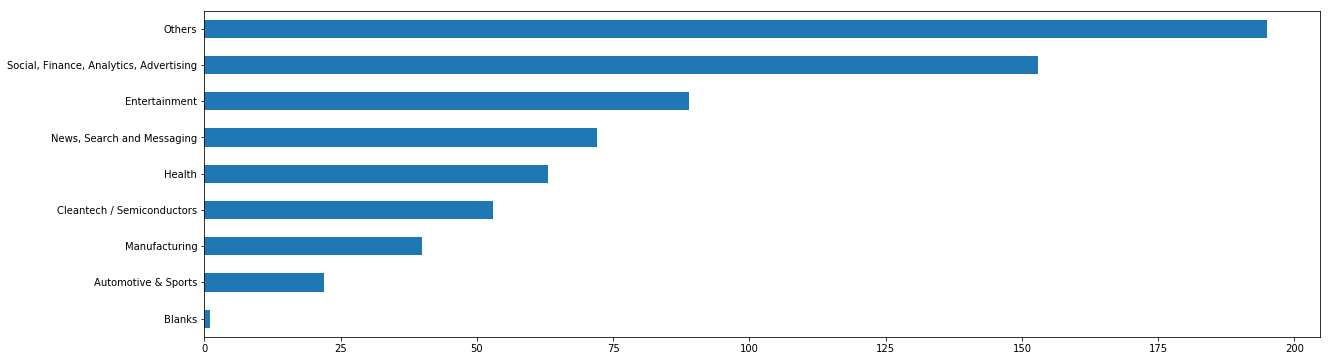

In [29]:
plt.figure(figsize=(20,6))
counts = mapping_new['main_sector'].value_counts()
ax = counts.iloc[:].plot(kind="barh")
ax.invert_yaxis()

##### Drop row where main_sector='Blanks'


Number of Records in filtered mapping file:  687


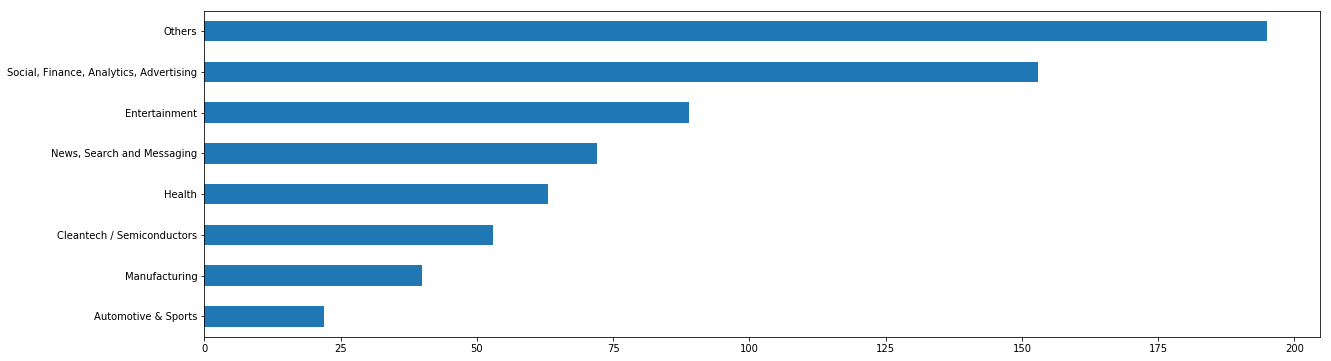

In [30]:
mapping_new.drop(mapping_new[mapping_new['main_sector']=='Blanks'].index,inplace=True)
print('\nNumber of Records in filtered mapping file: ',mapping_new.shape[0])

plt.figure(figsize=(20,6))
counts = mapping_new['main_sector'].value_counts()
ax = counts.iloc[:].plot(kind="barh")
ax.invert_yaxis()

##### Merge Top3 data with mapping

In [31]:
top3_data_sector_wise = pd.merge(left=top3_data, right=mapping_new,left_on='primary_sector',right_on='category_list')
# Drop unnecessary columns
top3_data_sector_wise.drop(labels=['category_list_x', 'category_list_y'],axis=1, inplace=True)

print('\nNumber of Records: ',top3_data_sector_wise.count()[0])
top3_data_sector_wise.head(3)


Number of Records:  41113


,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,Media,Entertainment
1,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.00,Media,Entertainment
2,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.00,Media,Entertainment


<font color='blue'>'top3_data_sector_wise' is the final dataframe after Checkpoint 4 contains the data of top 3 english speaking countries along with main_sector for each category list.</font>
* --------------------------------------------------------------------------------------------------------------

## Checkpoint 5: Sector Analysis 2

Created three separate data frames D1, D2 and D3 for each of the three english countries containing the observations of funding type falling within the 5-15 million USD range.
The three data frames contains:
1. All the columns of the master_frame along with the primary sector and the main sector
2. The total number (or count) of investments for each main sector in a separate column
3. The total amount invested in each main sector in a separate column

In [32]:
#USA
D1 = top3_data_sector_wise[top3_data_sector_wise['country_code']==top]

#GBR
D2 = top3_data_sector_wise[top3_data_sector_wise['country_code']==second]

#IND
D3 = top3_data_sector_wise[top3_data_sector_wise['country_code']==third]


#### Add two columns('count_sector_wise' & 'sum_sector_wise') in D1, D2 & D3 dataframes

In [33]:
#D1
D1['count_sector_wise'] = D1.groupby(by='main_sector')['permalink'].transform('count')
D1['sum_sector_wise'] = D1.groupby(by='main_sector')['raised_amount_usd'].transform('sum')

#D2
D2['count_sector_wise'] = D2.groupby(by='main_sector')['permalink'].transform('count')
D2['sum_sector_wise'] = D2.groupby(by='main_sector')['raised_amount_usd'].transform('sum')

#D3
D3['count_sector_wise'] = D3.groupby(by='main_sector')['permalink'].transform('count')
D3['sum_sector_wise'] = D3.groupby(by='main_sector')['raised_amount_usd'].transform('sum')

#### Q1. Total number of Investments (count)

In [34]:
print(D1.count()[0])
print(D2.count()[0])
print(D3.count()[0])

37871
2258
984


 #### Q2. Total amount of investment (USD)

In [35]:
print(D1.raised_amount_usd.sum())
print(D2.raised_amount_usd.sum())
print(D3.raised_amount_usd.sum())

418595223442.0
19983803406.0
14261508718.0


<font color='blue'><b>UDF to add count of investment & sum of investment in each sector</b?</font>

getSector(dataset,n,identifier) will give you 'name of the sector' or 'count of investments in sectors' based on the parameter value.

In [36]:
def getSector(dataset,n,identifier):
    '''
    dataset     :: datframe
    n           :: n represents nth order, 0 for top, 1 for second top and so on.
    identifier  :: identifier = 'count' to get the count, identifier = 'name' to get the sector name.
    '''
    if identifier == 'name':
        return (dataset.groupby(by='main_sector')['main_sector'].count().sort_values(ascending=False).index[n])
    elif identifier == 'count':
        return (dataset.groupby(by='main_sector')['main_sector'].count().sort_values(ascending=False)[n])

In [37]:
print(getSector(dataset=D1,n=0,identifier='name'))
print(getSector(dataset=D2,n=0,identifier='name'))
print(getSector(dataset=D3,n=0,identifier='name'))

Others
Others
Others


<font color='blue'> As Top Sector is coming as 'Others' for all top 3 countries, we will not consider 'Others' and start from second top to fourth top</font>

#### Q3. Top sector (based on count of investments)

In [38]:
D1_sec1_name = getSector(dataset=D1,n=1,identifier='name')
D2_sec1_name = getSector(D2,1,'name')
D3_sec1_name = getSector(D3,1,'name')

print('D1_sec1_name : ',D1_sec1_name,'\nD2_sec1_name : ',D2_sec1_name,'\nD3_sec1_name : ',D3_sec1_name)

D1_sec1_name :  Cleantech / Semiconductors 
D2_sec1_name :  Social, Finance, Analytics, Advertising 
D3_sec1_name :  Social, Finance, Analytics, Advertising


#### Q4. Second-best sector (based on count of investments)

In [39]:
D1_sec2_name = getSector(D1,2,'name')
D2_sec2_name = getSector(D2,2,'name')
D3_sec2_name = getSector(D3,2,'name')

print('D1_sec2_name : ',D1_sec2_name,'\nD2_sec2_name : ',D2_sec2_name,'\nD3_sec2_name : ',D3_sec2_name)

D1_sec2_name :  Social, Finance, Analytics, Advertising 
D2_sec2_name :  Cleantech / Semiconductors 
D3_sec2_name :  News, Search and Messaging


#### Q5. Third-best sector (based on count of investments)

In [40]:
D1_sec3_name = getSector(D1,3,'name')
D2_sec3_name = getSector(D2,3,'name')
D3_sec3_name = getSector(D3,3,'name')

print('D1_sec3_name : ',D1_sec3_name,'\nD2_sec3_name : ',D2_sec3_name,'\nD3_sec3_name : ',D3_sec3_name)

D1_sec3_name :  News, Search and Messaging 
D2_sec3_name :  News, Search and Messaging 
D3_sec3_name :  Entertainment


#### Q6. Number of investments in the top sector (refer to point 3)

In [41]:
D1_sec1_count = getSector(D1,1,'count')
D2_sec1_count = getSector(D2,1,'count')
D3_sec1_count = getSector(D3,1,'count')

print('D1_sec1_count : ',D1_sec1_count,'\nD2_sec1_count : ',D2_sec1_count,'\nD3_sec1_count : ',D3_sec1_count)

D1_sec1_count :  8121 
D2_sec1_count :  481 
D3_sec1_count :  193


#### Q7. Number of investments in the second-best sector (refer to point 4)

In [42]:
D1_sec2_count = getSector(D1,2,'count')
D2_sec2_count = getSector(D2,2,'count')
D3_sec2_count = getSector(D3,2,'count')

print('D1_sec2_count : ',D1_sec2_count,'\nD2_sec2_count : ',D2_sec2_count,'\nD3_sec2_count : ',D3_sec2_count)

D1_sec2_count :  7822 
D2_sec2_count :  460 
D3_sec2_count :  154


#### Q8. Number of investments in the third-best sector (refer to point 5)

In [43]:
D1_sec3_count = getSector(D1,3,'count')
D2_sec3_count = getSector(D2,3,'count')
D3_sec3_count = getSector(D3,3,'count')

print('D1_sec3_count : ',D1_sec3_count,'\nD2_sec3_count : ',D2_sec3_count,'\nD3_sec3_count : ',D3_sec3_count)

D1_sec3_count :  4612 
D2_sec3_count :  265 
D3_sec3_count :  90


#### Q9. For the top sector count-wise (point 3), which company received the highest investment?

In [44]:
# Filter dataframes by top-sector names(Q3), then group by company name and sum the raised_amount_usd, then fetch highest value
D1_com1_invt = D1[D1.main_sector == D1_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D2_com1_invt = D2[D2.main_sector == D2_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D3_com1_invt = D3[D3.main_sector == D3_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]

print('D1_com1_invt : ',D1_com1_invt,'\nD2_com1_invt : ',D2_com1_invt,'\nD3_com1_invt : ',D3_com1_invt)

D1_com1_invt :  Freescale Semiconductor 
D2_com1_invt :  Powa Technologies 
D3_com1_invt :  ShopClues.com


#### Q10. For the second-best sector count-wise (point 4), which company received the highest investment?

In [45]:
D1_com2_invt = D1[D1.main_sector == D1_sec2_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D2_com2_invt = D2[D2.main_sector == D2_sec2_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D3_com2_invt = D3[D3.main_sector == D3_sec2_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]

print('D1_com2_invt : ',D1_com2_invt,'\nD2_com2_invt : ',D2_com2_invt,'\nD3_com2_invt : ',D3_com2_invt)

D1_com2_invt :  Groupon 
D2_com2_invt :  ReNeuron Group 
D3_com2_invt :  FreeCharge


* --------------------------------------------------------------------------------------------------------------
## Checkpoint 6: Plots

#### Q1. A plot showing the fraction of total investments (globally) in venture, seed, angel and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

##### Using Matplotlib

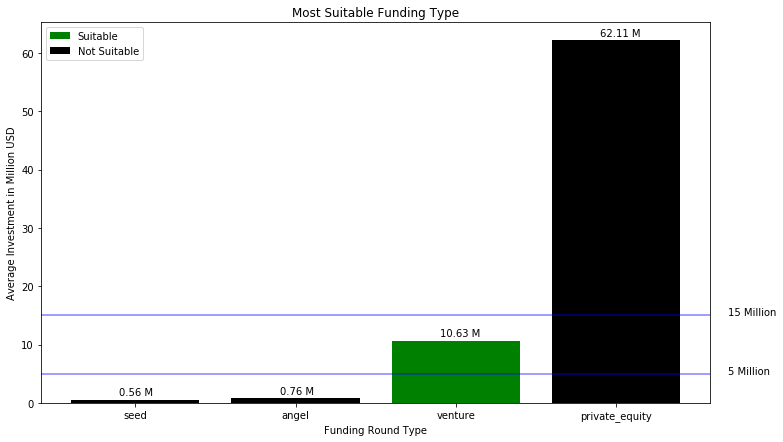

In [46]:
selected_funding_round_type = ['venture','seed','private_equity','angel']
plot_frame = master_frame_imputed.loc[master_frame_imputed.funding_round_type.isin(selected_funding_round_type)]
plot_frame = plot_frame.groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending=True).reset_index()

cond = ((plot_frame.raised_amount_usd >= 5000000) & (plot_frame.raised_amount_usd <= 15000000))

x = range(len(plot_frame.funding_round_type))
y = plot_frame.raised_amount_usd/ 1000000
y1 = y[cond]
y2 = y[~cond]
x1 = list(y1.index)
x2 = list(y2.index)


plt.figure(figsize=(12,7))

# Bar plot
#plt.bar(x,y, color=cond.map({True: 'g', False: 'k'}),label ='Suitable' )
plt.bar(x1,y1, color='g',label ='Suitable' )
plt.bar(x2,y2, color='k',label ='Not Suitable' )


# Title
plt.title('Most Suitable Funding Type')

# Labels
plt.xlabel('Funding Round Type')
plt.ylabel('Average Investment in Million USD')

# Ticks
plt.xticks(x, plot_frame.funding_round_type)

# Horizontal Line
plt.axhline(y=5, color='b', linestyle='-',alpha = 0.5)
plt.text(max(x)+.7, 5,'5 Million')
plt.axhline(y=15, color='b', linestyle='-',alpha = 0.5)
plt.text(max(x)+.7, 15,'15 Million')

# Add Values to the bar
for i in x:
    plt.text(x[i]-.1,y[i]+.75,str(round(y[i],2))+' M')

# Legend
plt.legend()

# Show plot
plt.show()

<font color='blue'> This chart makes it clear that why <b>'Venture'</b> funding type is best suited for Spark Funds</font>

#### Q2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

##### Using Seaborn

[Text(0,0.5,'Raised Amount USD(in Billions)'), Text(0.5,0,'Country Code')]

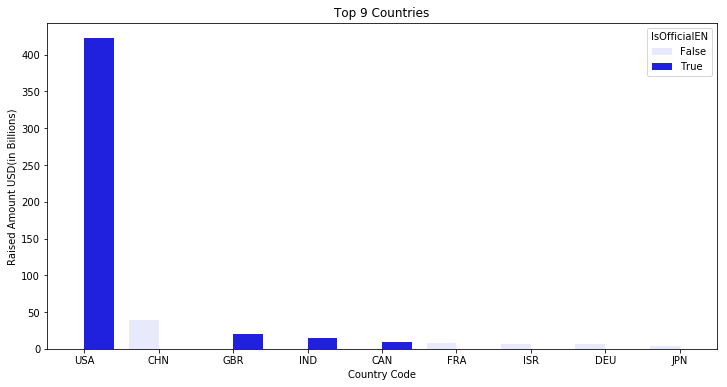

In [47]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.set_title('Top 9 Countries')
ax = sns.barplot(x = top9['country_code'], y=(top9['raised_amount_usd']/1000000000), hue=top9['IsOfficialEN'],color='b')
ax.set(xlabel='Country Code', ylabel='Raised Amount USD(in Billions)')


#### Q3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

##### Using Seaborn

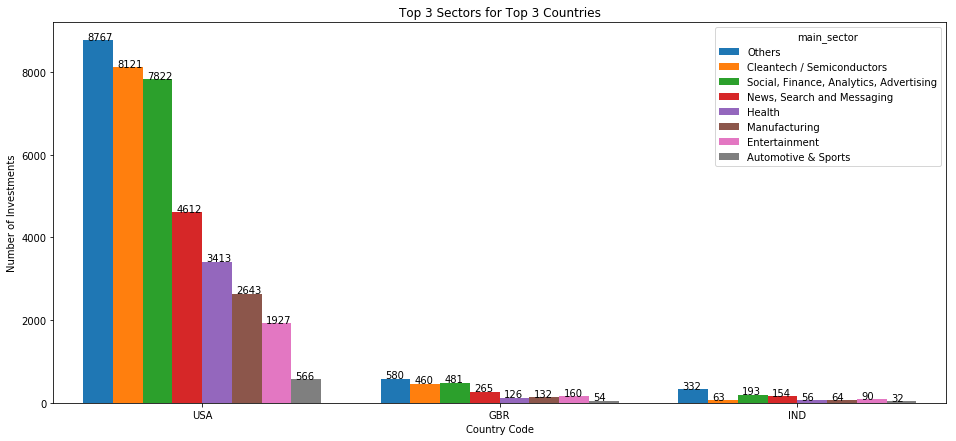

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 7)
ax.set_title('Top 3 Sectors for Top 3 Countries')
ax = sns.countplot(data = top3_data_sector_wise, x = 'country_code',hue='main_sector',order = ['USA','GBR','IND'],\
                 hue_order = top3_data_sector_wise['main_sector'].value_counts().index,saturation =1)
ax.set(xlabel='Country Code', ylabel='Number of Investments')

for p in ax.patches:
        ax.annotate((p.get_height()),(p.get_x()+0.014, p.get_height()+10))

*****